In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spherical_yn, spherical_jn

In [63]:
m1 = 939.565 #MeV/c^2
m2 = 3727.379 #MeV/c^2
hbar = 197 #MeV

mu = m1*m2/(m1+m2)

V0 = 10
a = 6 #fm

h = 0.001 #step size
p = 1 #initial condition for derivative



In [64]:
def V(r):
    return -V0 if r <= a else 0

In [65]:
def F(l, r, E):
    return (2*mu/(hbar**2)*(V(r)-E) + (l*(l+1)/(r**2)))

Matching via logarithmic derivative

In [66]:
def y_l(r, l, E):
    r_values = np.arange(0, a + 2*h, h) # need one step beyond well
    N = len(r_values)

    y = np.zeros(N)
    z = np.zeros(N)

    y[0] = 0.0
    y[1] = p * h
    z[0] = 0.0
    z[1] = p * h

    for i in range(1, N-1):
        r_cur = r_values[i]
        F_val = F(l, r_cur, E)
        z[i+1] = (2*z[i] - z[i-1] + (h**2 * F_val * z[i]))
        y[i] = (1-(h**2/12*F_val))*z[i]
    
    return y

In [67]:
def y_prime(y):
    r2_index = len(y)-1
    r1_index = r2_index-2
    return ((y[r2_index]-y[r1_index])/(2*h))

In [68]:
def calculate_phase_shift(k, l, E):

    ka = k * a

    y_array = y_l(a, l, E)
    y_val = y_array[len(y_array)-2] #at boundary
    y_prime_val = y_prime(y_array)
    
    delta_l = np.arctan2( (y_prime_val*spherical_jn(l, ka) - k*y_val*spherical_jn(l, ka, True)), (k*y_val*(-1)*spherical_yn(l, ka, True) - y_prime_val*(-1)*spherical_yn(l, ka)) )

    return delta_l

In [69]:
def calculate_total_cross_sections(E_values, l_max):
    cross_sections = []
    for E in E_values:
        k = np.sqrt((2*mu*E)/hbar**2)
        total_cross_section = 0.
        for l in range(l_max + 1):
            delta_l = calculate_phase_shift(k, l, E)
            total_cross_section += (2*l + 1) * (np.sin(delta_l)) ** 2
        cross_sections.append((4*np.pi / (k ** 2)) * total_cross_section)
    return cross_sections

In [70]:
E_values = np.linspace(0.1, 20.0, 100)
l_max = 0

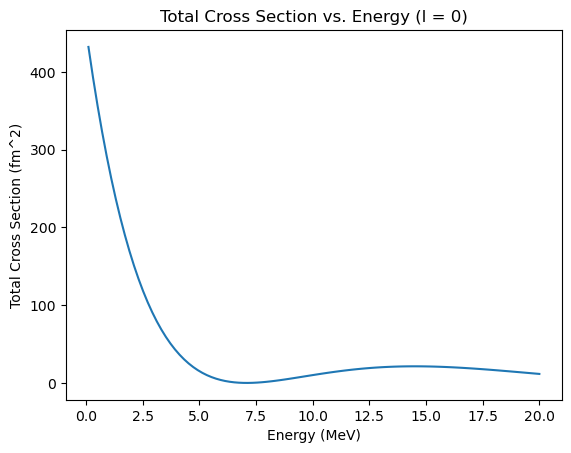

In [71]:
cross_sections = calculate_total_cross_sections(E_values, l_max)

plt.plot(E_values, cross_sections)
plt.xlabel("Energy (MeV)")
plt.ylabel("Total Cross Section (fm^2)")
plt.title(f"Total Cross Section vs. Energy (l = {l_max})")
plt.show()

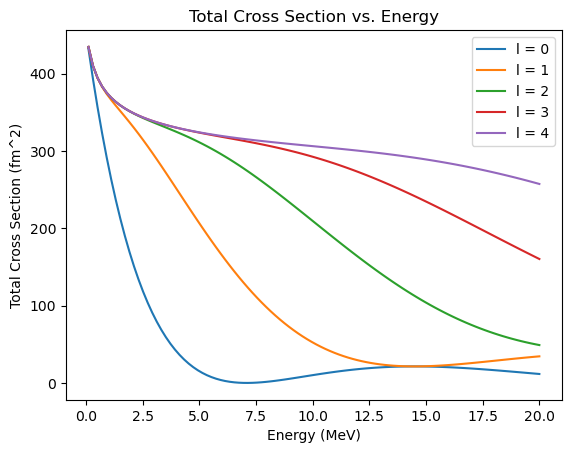

In [72]:
cross_sections_0 = calculate_total_cross_sections(E_values, 0)
cross_sections_1 = calculate_total_cross_sections(E_values, 1)
cross_sections_2 = calculate_total_cross_sections(E_values, 2)
cross_sections_3 = calculate_total_cross_sections(E_values, 3)
cross_sections_4 = calculate_total_cross_sections(E_values, 4)

plt.plot(E_values, cross_sections_0, label='l = 0')
plt.plot(E_values, cross_sections_1, label='l = 1')
plt.plot(E_values, cross_sections_2, label='l = 2')
plt.plot(E_values, cross_sections_3, label='l = 3')
plt.plot(E_values, cross_sections_4, label='l = 4')
plt.xlabel("Energy (MeV)")
plt.ylabel("Total Cross Section (fm^2)")
plt.title("Total Cross Section vs. Energy")
plt.legend()
plt.show()

In [73]:
k_array = np.sqrt(2*mu*E_values / (hbar ** 2))

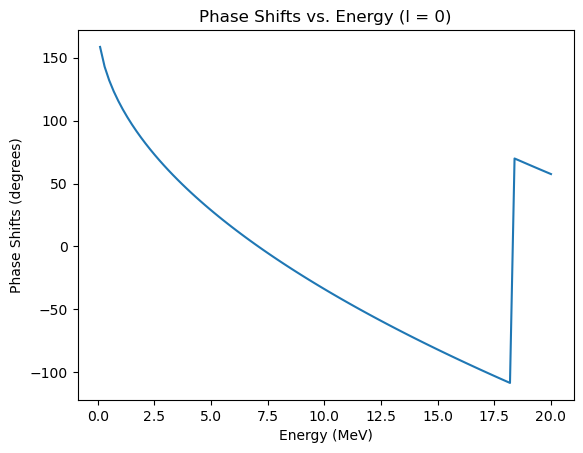

In [74]:
phase_shifts = []
l = 0

for k, E in zip(k_array, E_values):
    phase_shift = calculate_phase_shift(k, l, E)  
    phase_shifts.append(phase_shift)

phase_shifts_degrees = np.array(phase_shifts) * 180 / np.pi

plt.plot(E_values, phase_shifts_degrees)
plt.xlabel("Energy (MeV)")
plt.ylabel("Phase Shifts (degrees)")
plt.title(f"Phase Shifts vs. Energy (l = {l})")
plt.show()